In [1]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from IoTTotalFeature import CIoTTotalFeature
from IoTSample import CIoTSample
from SHSample import CSHSample
from IoTPrompt import CIoTPrompt
from SHDataProcess import CSHDataProcess
from SHFeatureSelect import CSHFeature
from Config import g_data_root,get_attack_score
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHModelRegression import CSHModelRegression
from SHModelClassify import CSHModelClassify
from IoTScore import CIoTScore,CIoTScoreTest,Create_Score_Sample,Create_Normal_Sample
from SHEvaluation import CSHROC
from IoTDatabase import CIoTDbSample
from IoTNoise import CIoTNoise
import warnings
import numpy as np
import matplotlib.pyplot as plt
from Config import g_data_root
from datetime import datetime
warnings.simplefilter("ignore")
g_token_root = "%stoken/"%g_data_root
g_tmp_root = "%stmp/"%g_data_root

XSS_attacks


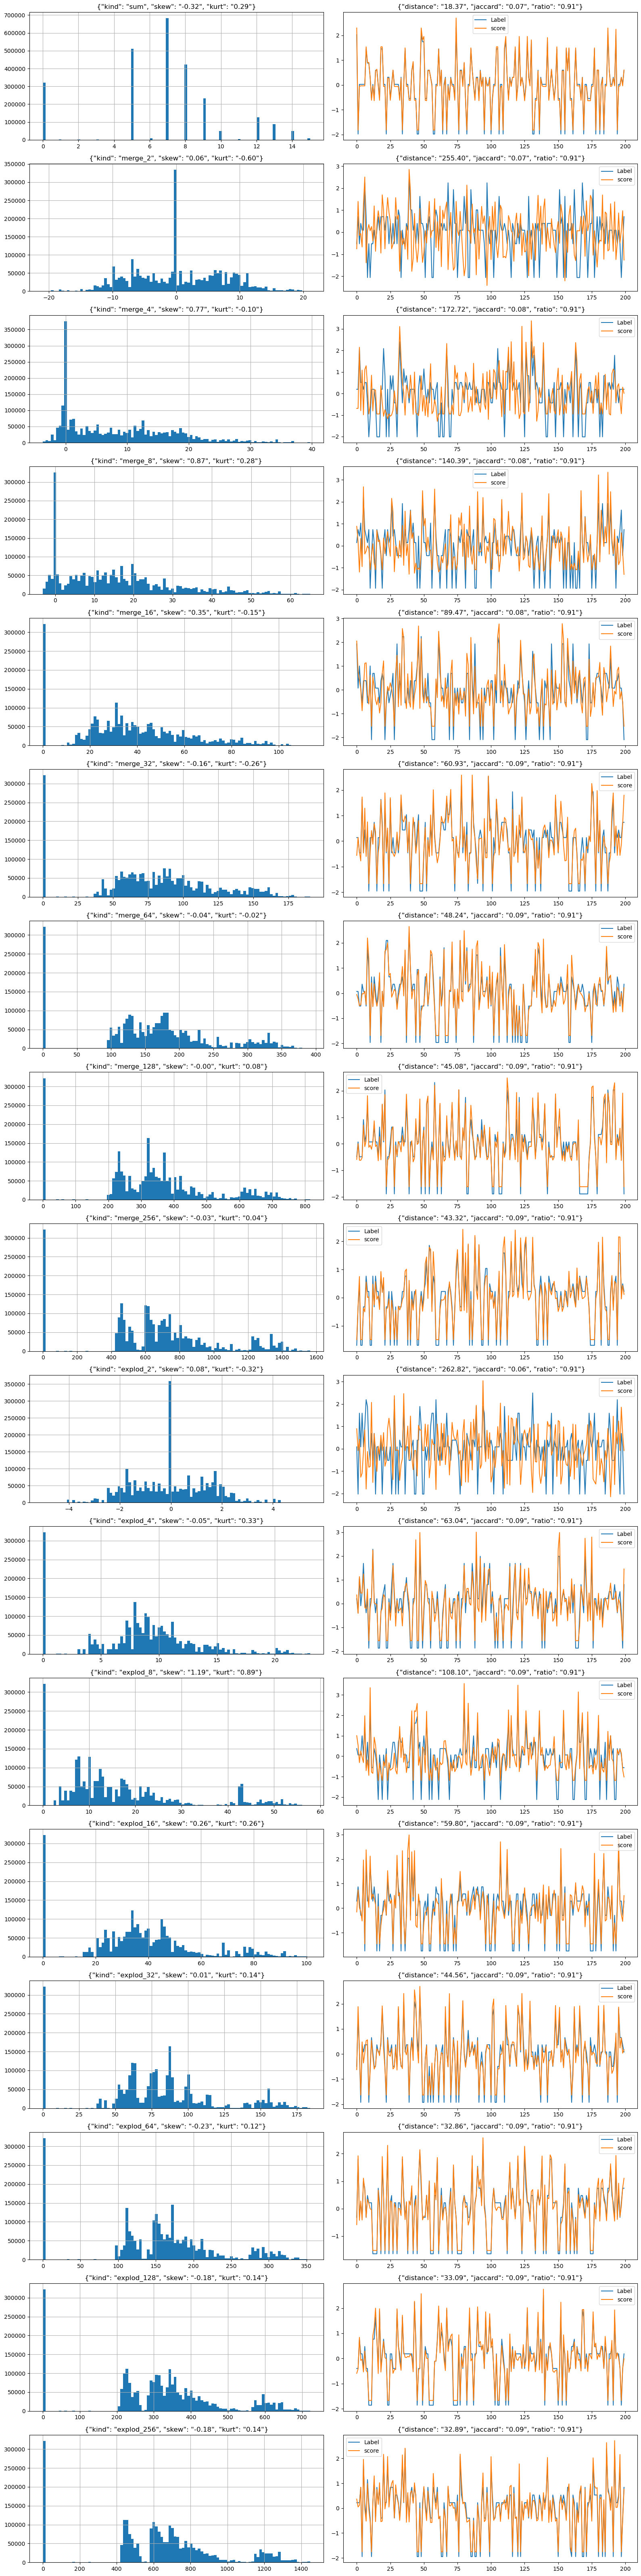

In [4]:
attack = "XSS_attacks"
ioTScore = CIoTScoreTest(attack)
df_tmp = ioTScore.get_result()
print(attack)
ioTScore.show_result(df_tmp,n_samples=200)

In [5]:
df_tmp

,attack,kind,distance,jaccard,skew,kurt,group,Label,Level,score
0,XSS_attacks,A.sum,18.37321877,0.06891620,-0.31849587,0.28615792,0,8,0,592.00000000
1,XSS_attacks,A.sum,18.37321877,0.06891620,-0.31849587,0.28615792,1,8,0,592.00000000
2,XSS_attacks,A.sum,18.37321877,0.06891620,-0.31849587,0.28615792,2,8,0,592.00000000
3,XSS_attacks,A.sum,18.37321877,0.06891620,-0.31849587,0.28615792,3,8,0,592.00000000
4,XSS_attacks,A.sum,18.37321877,0.06891620,-0.31849587,0.28615792,4,8,0,592.00000000
...,...,...,...,...,...,...,...,...,...,...
610482,XSS_attacks,R.explod_256,32.88849118,0.08789086,-0.17946898,0.13638415,35906,0,0,0.00000000
610483,XSS_attacks,R.explod_256,32.88849118,0.08789086,-0.17946898,0.13638415,35907,0,0,0.00000000
610484,XSS_attacks,R.explod_256,32.88849118,0.08789086,-0.17946898,0.13638415,35908,0,0,0.00000000
610485,XSS_attacks,R.explod_256,32.88849118,0.08789086,-0.17946898,0.13638415,35909,0,0,0.00000000
